In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

In [2]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName
TimeStamp,,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00


In [3]:
#Voltage_df=df.drop("CurrentCurve", axis=1)
#Current_df=df.drop("VoltageCurve", axis=1)

In [4]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

In [5]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

In [6]:
#quali dati hanno la massima numerosità (624) di raccolte
#exploded_voltage[exploded_voltage[623].notna()].head()
#per selezionare la prima riga
#exploded_voltage.iloc[0]
#oppure
#exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]

## Analisi esplorativa su exploded_voltage
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: voglio escluderle dal calcolo della curva media che userò come riferimento.

<AxesSubplot:>

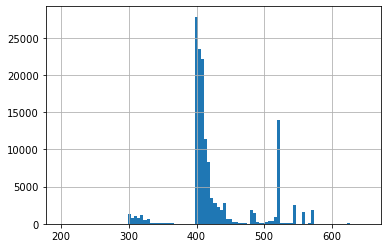

In [7]:
exploded_voltage.count(axis=1).hist(bins=100,range=(200,650))

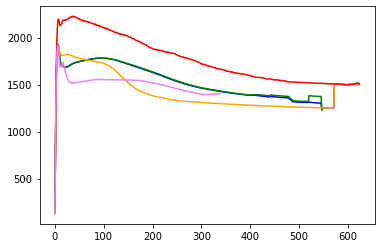

In [49]:
#plotto la curva media di tutti i valori
plot(exploded_voltage.mean(axis=0),"blue")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>550].mean(axis=0),"orange")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>600].mean(axis=0),"red")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<340].mean(axis=0),"violet")

è interessante notare l'andamento delle curve sulla base della numerosità delle rilevazioni fatte:
-   curve con più di 600 o meno di 300 rilevazioni sono chiaramente delle anomalie

Voglio isolare quelle curve che hanno avuto un picco (o un calo) improvviso della tensione, che ne ha modificato l'andamento (anomalia strutturale)

In [89]:
#calcolo il differenziale tra valori successivi 
voltage_lag=exploded_voltage.diff(periods=5,axis=1)
#voltage_lag.mean(axis=0).head(20)

In [94]:
#creazione upper e lower limit come per Normale (mean +- 2*std)
upper_lag=voltage_lag.apply(lambda x : x.mean()+4*x.std(),axis=0)
lower_lag=voltage_lag.apply(lambda x : x.mean()-4*x.std(),axis=0)
#creazione upper e lower usando i quantili
upper_lag2=voltage_lag.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_lag2=voltage_lag.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

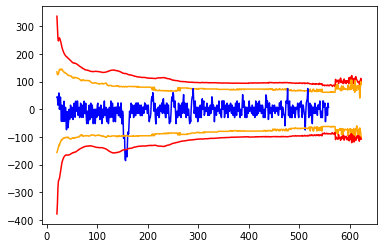

In [104]:
plot(upper_lag[20:],"red")
plot(upper_lag2[20:],"orange")
plot(voltage_lag.iloc[590][20:],"blue")
plot(lower_lag2[20:],"orange")
plot(lower_lag[20:],"red")

[]

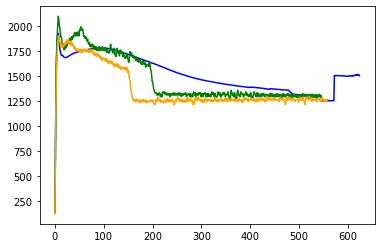

In [103]:
plot(exploded_voltage.mean(axis=0),"blue")
plot(exploded_voltage.iloc[20],"green")
plot(exploded_voltage.iloc[590],"orange")
plot()

## Approccio statistico

In [7]:
exploded_voltage.head()

0      1       2       3       4       5    \
spotName   TimeStamp                                                         
60000_0_00 2019-11-07 12:29:06  132  744.0  1299.0  1663.0  1894.0  2002.0   
           2019-11-07 12:29:26  136  752.0  1308.0  1675.0  1923.0  2068.0   
           2019-11-07 12:29:26  139  757.0  1292.0  1655.0  1885.0  2042.0   
           2019-11-07 12:29:30  133  743.0  1286.0  1645.0  1887.0  2046.0   
           2019-11-07 12:29:32  137  755.0  1313.0  1683.0  1906.0  2043.0   

                                   6       7       8       9    ...  614  615  \
spotName   TimeStamp                                            ...             
60000_0_00 2019-11-07 12:29:06  2068.0  2110.0  2076.0  2035.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2128.0  2180.0  2180.0  2103.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2099.0  2099.0  2099.0  2067.0  ...  NaN  NaN   
           2019-11-07 12:29:30  2104.0  2104.0  2129.0  2079.0  ...  NaN  NaN   
           2019-11-07 12:29:32  2147.0  2189.0  2155.0  2104.0  ...  NaN  NaN   

                                616  617  618  619  620  621  622  623  
spotName   TimeStamp                                                    
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 624 columns]

Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [10]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_voltage.apply(lambda x : x.mean()+2*x.std(),axis=0)
lower_limit=exploded_voltage.apply(lambda x : x.mean()-2*x.std(),axis=0)

In [11]:
#creazione upper e lower usando i quantili
upper_limit2=exploded_voltage.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_limit2=exploded_voltage.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

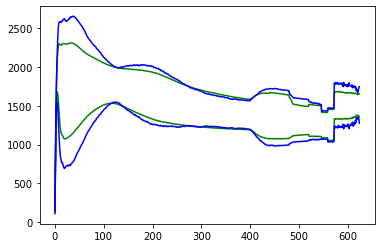

In [14]:
#plottiamo i limiti per vedere come si comportano (in blu limiti con la std, in verde con i percentili)
plot(upper_limit,"green")
plot(lower_limit,"green")

plot(upper_limit2,"blue")
plot(lower_limit2,"blue")

In [80]:
voltage_lag.iloc[10].head(10)

0      NaN
1    615.0
2    526.0
3    289.0
4    163.0
5     89.0
6      0.0
7    -59.0
8    -81.0
9    -67.0
Name: (60052_0_00, 2019-11-08 17:51:29), dtype: float64

notiamo come dal 15° valore circa i differenziali assumono valori molto bassi, ad indicare l'assestamento della curva che dopo 2 oscillazioni tende a stazionare su valori simili

**NB:** Voglio creare una curva media escludendo dal campione quelle curve che hanno avuto un calo improvviso della tensione e che quindi influirebbero sulla costruione della curva di riferimento: vedi grafico delle slide (**da ricreare**). 

In [14]:
import numpy as np
import scipy.stats as st
from pylab import *

In [27]:
voltage_lag.head(15)

0      1      2      3      4      5      6    \
spotName   TimeStamp                                                            
60000_0_00 2019-11-07 12:29:06  NaN  612.0  555.0  364.0  231.0  108.0   66.0   
           2019-11-07 12:29:26  NaN  616.0  556.0  367.0  248.0  145.0   60.0   
           2019-11-07 12:29:26  NaN  618.0  535.0  363.0  230.0  157.0   57.0   
           2019-11-07 12:29:30  NaN  610.0  543.0  359.0  242.0  159.0   58.0   
           2019-11-07 12:29:32  NaN  618.0  558.0  370.0  223.0  137.0  104.0   
...                             ...    ...    ...    ...    ...    ...    ...   
60001_0_00 2020-05-28 15:00:04  NaN  618.0  535.0  355.0  222.0  165.0   65.0   
60021_0_00 2020-05-28 15:00:04  NaN  639.0  555.0  343.0  213.0  120.0   92.0   
60023_0_00 2020-05-28 15:00:17  NaN  630.0  534.0  349.0  201.0  123.0  131.0   
60025_0_00 2020-05-28 15:00:17  NaN  629.0  521.0  318.0  177.0   84.0   83.0   
60027_0_00 2020-05-28 15:00:17  NaN  608.0  520.0  336.0  184.0  120.0   40.0   

                                 7     8     9    ...  614  615  616  617  \
spotName   TimeStamp                              ...                       
60000_0_00 2019-11-07 12:29:06  42.0  34.0  41.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:26  52.0   0.0  77.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:26   0.0   0.0  32.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:30   0.0  25.0  50.0  ...  NaN  NaN  NaN  NaN   
           2019-11-07 12:29:32  42.0  34.0  51.0  ...  NaN  NaN  NaN  NaN   
...                              ...   ...   ...  ...  ...  ...  ...  ...   
60001_0_00 2020-05-28 15:00:04  16.0   0.0  41.0  ...  NaN  NaN  NaN  NaN   
60021_0_00 2020-05-28 15:00:04  93.0   0.0   9.0  ...  NaN  NaN  NaN  NaN   
60023_0_00 2020-05-28 15:00:17  35.0   9.0   0.0  ...  NaN  NaN  NaN  NaN   
60025_0_00 2020-05-28 15:00:17  26.0  17.0  42.0  ...  NaN  NaN  NaN  NaN   
60027_0_00 2020-05-28 15:00:17  16.0   0.0  32.0  ...  NaN  NaN  NaN  NaN   

                                618  619  620  621  622  623  
spotName   TimeStamp                                          
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  NaN  NaN  
...                             ...  ...  ...  ...  ...  ...  
60001_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  NaN  NaN  
60021_0_00 2020-05-28 15:00:04  NaN  NaN  NaN  NaN  NaN  NaN  
60023_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  
60025_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  
60027_0_00 2020-05-28 15:00:17  NaN  NaN  NaN  NaN  NaN  NaN  

[142192 rows x 624 columns]

Si nota un andamento anomalo dopo il 500° valore. Posso eliminare i circa ultimi 100 valori che probabilmente derivano da un processo viziato?

<AxesSubplot:>

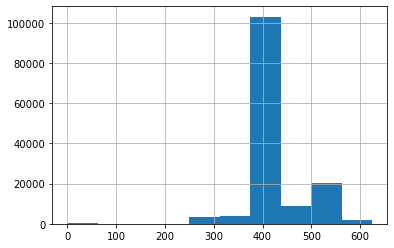

In [ ]:
#calcolo lunghezza di ogni lista e plot del relativo istogramma
len_lists=df['VoltageCurve'].str.len()
len_lists.hist()
# la maggior parte delle liste sembra avere una dimensione intorno ai 400 valori

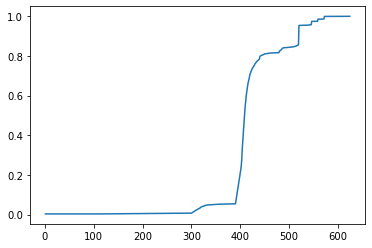

In [ ]:
# somma cumulata della distribuzione delle lunghezze
conta=len_lists.groupby(len_lists.values).count()
plot(conta.cumsum()/len(Voltage_df))
# le liste con meno di 500 valori rappresentano circa l'80% dei dati

Decido di considerare solo le raccolte con meno di 500 valori per la creazione della curva media/mediana

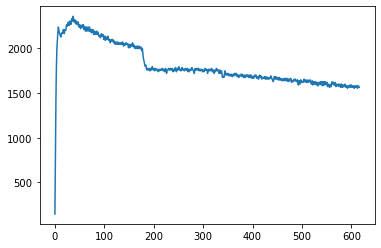

In [46]:
anomalie_volt=df["VoltageCurve"][df['VoltageCurve'].str.len()>600]
plot(anomalie_volt[10])